In [5]:
import pickle
import pandas as pd
import gensim
from gensim.parsing.preprocessing import (stem_text)
import pickle
import pandas as pd
import re
import string
import os


In [6]:
df = pd.read_pickle("../data/data_scraped_input.pkl")


print(df.head())


                                           Kategorie Quelle/Organisation  \
0                               Verbände / Templates   IT-Recht Hannover   
1                               Verbände / Templates     3H Solutions AG   
2                               Verbände / Templates        Common Paper   
3  Öffentlich zugängliche Verträge großer SaaS-An...                 SAP   
4  Öffentlich zugängliche Verträge großer SaaS-An...                 SAP   

                       Dokumententyp  \
0                Muster SaaS-Vertrag   
1  Standard-Vertragsbedingungen SaaS   
2            Cloud Service Agreement   
3                                NaN   
4                                NaN   

                                             Mapping Sprache  \
0  https://it-rechthannover.de/IT-Muster/SaaS-Ver...      DE   
1  Templates_3H_Solutions_AG_18-06_SaaS-Cloudsoft...      DE   
2  https://commonpaper.com/standards/cloud-servic...      EN   
3               SaaS_SAP_Service_Level_Agreeme

In [7]:
print(df.iloc[13,5])

Vertragsbedingungen SaaS-Vertrag
der TA Triumph-Adler Gruppe (Stand 01/2021)
Vertragsbedingungen SaaS-Vertrag der TA Triumph-Adler Gruppe
(Stand 01/2021) – Seite 1 von 5
1. Vertragsgegenstand, Anwendungsbereich
1.1. Diese „Vertragsbedingungen SaaS-Vertrag TA Triumph-Adler Gruppe“
(„Vertragsbedingungen“) sind Bestandteil des zwischen Auftragnehmer und
Auftraggeber (gemeinsam „Parteien“) abgeschlossenen Software as a
Service-Vertrags („SaaS-Vertrag“).
1.2. Bestandteil des SaaS-Vertrags sind je nach Vereinbarung im SaaS-Vertrag:
a) die entgeltliche Überlassung folgender Objekte:
- Softwareanwendung mittels Internet, soweit keine anderweitige
Telekommunikation ausdrücklich vereinbart wurde („Services“),
- und/oder
- Software („Vertragssoftware“) einschließlich der zugehörigen Beschreibung
der technischen Funktionalität, des Betriebs, der Installation und der Nutzung,
b) die Erbringung von Serviceleistungen an den Services,
c) die Erbringung von Softwarepflege- und -supportleistungen
(„SPS-

Since we want to classify paragraphs rather than whole Contracts we need to split the contracts in smaller chunks.

In [ ]:
def extract_paragraphs_and_sections(row):
    import re

    text = row['content']
    contract_id = row['contract']
    lines = text.splitlines()
    paragraphs = []
    current_para_lines = []
    current_para_number = None
    current_para_match = None

    # 1. extract paragraphs

    for line in lines:
        line = line.strip()
        if not line:
            continue

        match_main = re.match(r'(§\s*\d+|^\d+\.)\s+', line)

        if match_main:
            if current_para_lines:
                paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))
            current_para_number = match_main.group(1).strip().lstrip('§').rstrip('.')  # e.g. "14"
            current_para_match = match_main.group(0).strip()
            current_para_lines = [line]
        elif current_para_lines:
            current_para_lines.append(line)

    if current_para_lines:
        paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))

    rows = []
    seen_sections = set()  # (contract_id, para_num, section_id)

    for para_num, para_text, para_match in paragraphs:
        print(para_num)
        print(seen_sections)
        print(para_text)
        matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d+)(?=\s|[^0-9])', para_text))
        print(matches)

        if not matches:
            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': "no sections use paragraph",
                'section_content': para_text.strip()
            })
            continue

        positions = []
        for match in matches:
            section_id = match.group(1)
            start = match.start()

            # Parse the section number suffix (e.g. "5" from "1.5")
            try:
                section_suffix = int(section_id.split(".")[1])
            except (IndexError, ValueError):
                continue  # Skip malformed section IDs

            # Skip if suffix ends in another digit (i.e. "1.50")
            if re.match(rf'{para_num}\.\d{{2,}}$', section_id):
                continue

            # Enforce increasing order: only accept 1.5 if 1.4 was seen
            if last_section_number is not None and section_suffix != last_section_number + 1:
                continue

            section_key = (contract_id, para_num, section_id)
            if section_key in seen_sections:
                continue

    seen_sections.add(section_key)
    positions.append((start, section_id))
    last_section_number = section_suffix

        # Add end position
        positions.append((len(para_text), None))
        positions = sorted(positions)
        print(f'positions = {positions}')
        print('###########')

        for i in range(len(positions) - 1):
            start_pos = positions[i][0]
            end_pos = positions[i + 1][0]
            section_id = positions[i][1]
            section_text = para_text[start_pos:end_pos].strip()

            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': section_id,
                'section_content': section_text
            })

    return rows






def clean_paragraph_text(text):
    # 1. remove paragraph marker z. B. '§ 1' oder '1.'
    text = re.sub(r'^(§\s*\d+|\d+\.)\s+', '', text)
    text = re.sub(r'(?<!\d)(\d+\.\d+)(?=\s)', '',text)

    # 2. remove punctation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. remove double whitespaces
    text = re.sub(r'\s+', ' ', text)

    # 4. remove whitespace beginning and end
    return text.strip()




IndentationError: unexpected indent (185545178.py, line 82)

In [9]:
# filter df to relevant contracts
df_relevant = df[#(df['Kategorie'] == "kleinere SaaS-Anbieter (Hauptgruppe)") & 
                    (df['Sprache'] == "DE") #& (df['Quelle/Organisation'] != "Comarch ERP XT"	)
                    ]
df_relevant = df_relevant.iloc[:,[5]]
df_relevant.columns = ['content']
df_relevant["contract"] = range(1, df_relevant.shape[0] + 1)
df_relevant = df_relevant[['contract', 'content']]
df_relevant.head()

,contract,content
0,1,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...
1,2,Standard-Vertragsbedingungen\nSaaS- und Clouds...
3,3,SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...
4,4,ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...
5,5,SUPPORT SCHEDULE FÜR CLOUD SERVICES\nDieses Su...


In [22]:
# apply prargrah and section extractor
df_exploded = df_relevant.apply(extract_paragraphs_and_sections, axis=1)

print(df_exploded.head())
# flatten the lists to a df
from itertools import chain
flattened_rows = list(chain.from_iterable(df_exploded))

# build df
df_structured = pd.DataFrame(flattened_rows)
display(df_structured[["contract","paragraph","section"]])

 1


NameError: name 'sleep' is not defined

In [11]:
def extract_title_fixed(group):
    import re
    paragraph_text = group['paragraph_content'].iloc[0]
    section_texts = group['section_content'].tolist()

    # No Sections (single paragraph)
    if len(section_texts) == 1 and group['section'].iloc[0] == "no sections use paragraph":
        # find sentence end
        match = re.search(r'\b(Der|Die|Das|Es|Ein|Eine)\s+[A-ZÄÖÜ][a-zäöü]+\b', paragraph_text)
        if match:
            title = paragraph_text[:match.start()].strip()
        else:
            # Fallback: to first verb or 8 words
            title = ' '.join(paragraph_text.split()[:8])
        return pd.Series([title] * len(group), index=group.index)

    # secction split
    for section in section_texts:
        paragraph_text = paragraph_text.replace(section, '')
    title = paragraph_text.strip()
    return pd.Series([title] * len(group), index=group.index)


df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)
# select cols

df_structured = df_structured[
    ['contract', 'paragraph', 'paragraph_title', 'paragraph_content', 'section', 'section_content']
]

# remove title
df_structured['paragraph_title'] = df_structured.apply(
    lambda row: row['paragraph_title'].replace(row['paragraph'], '').strip() if pd.notnull(row['paragraph_title']) else '',
    axis=1
)


df_structured["clean_paragraph_content"] = df_structured["paragraph_content"].apply(clean_paragraph_text)
df_structured["clean_section_content"] = df_structured["section_content"].apply(clean_paragraph_text)


df_structured["clean_paragraph_content"] = df_structured.apply(
    lambda row: row["clean_paragraph_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["clean_paragraph_content"]) else '',
    axis=1
)

df_structured["clean_section_content"] = df_structured.apply(
    lambda row: row["clean_section_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["clean_section_content"]) else '',
    axis=1
)

print(df_structured.shape)

/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_3785/407956741.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


(987, 8)


In [12]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [13]:
from transformers import BertTokenizer
bert_uncased = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/dave/Desktop/BIPM/05_NLP/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
df_structured["paragraph_content_stemm"]=df_structured['clean_paragraph_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_content_lemma"]=df_structured['clean_paragraph_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_content_token"]=df_structured['clean_paragraph_content'].apply(
    lambda text: bert_uncased.tokenize(text)
)

In [15]:
df_structured["section_content_stemm"]=df_structured['clean_section_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_section_lemma"]=df_structured['clean_section_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_section_token"]=df_structured['clean_section_content'].apply(
    lambda text: bert_uncased.tokenize(text)
)

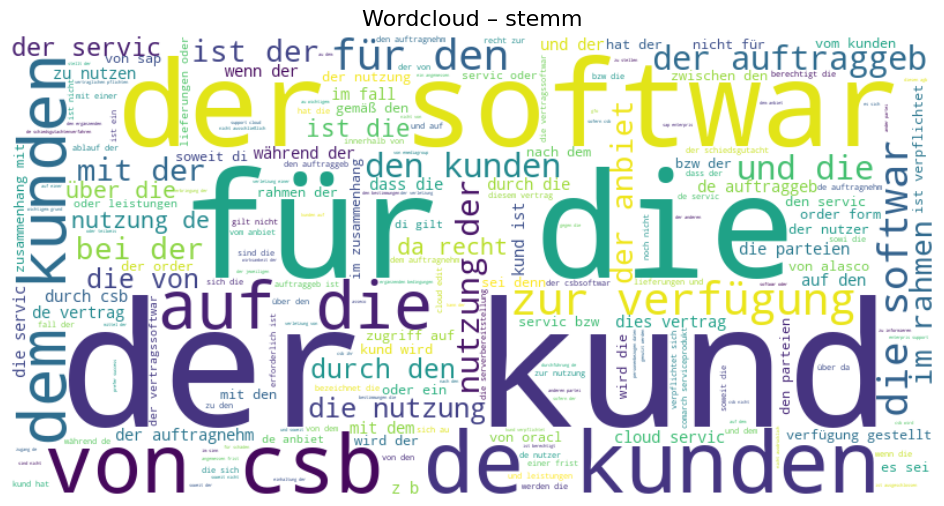

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
topic_text = " ".join(df_structured["paragraph_content_stemm"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – stemm", fontsize=16)
plt.show()

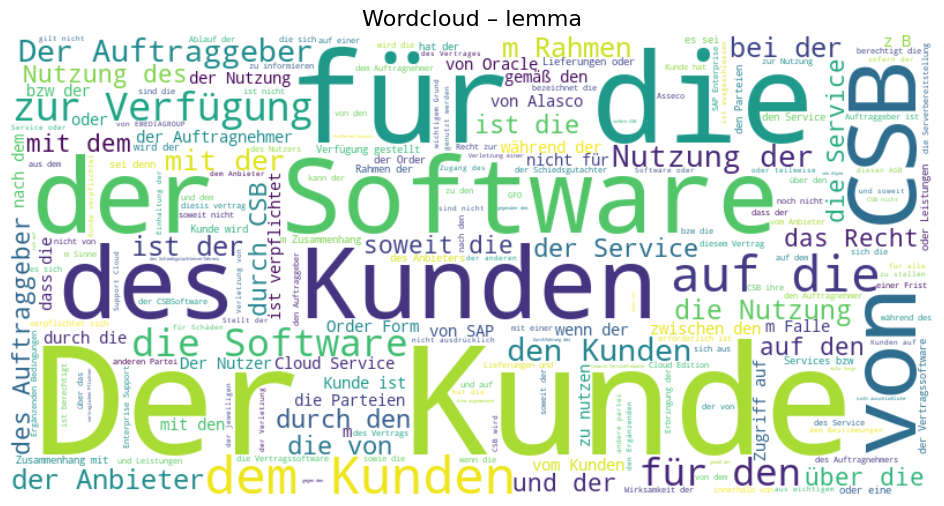

In [17]:
topic_text = " ".join(df_structured["paragraph_content_lemma"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – lemma", fontsize=16)
plt.show()

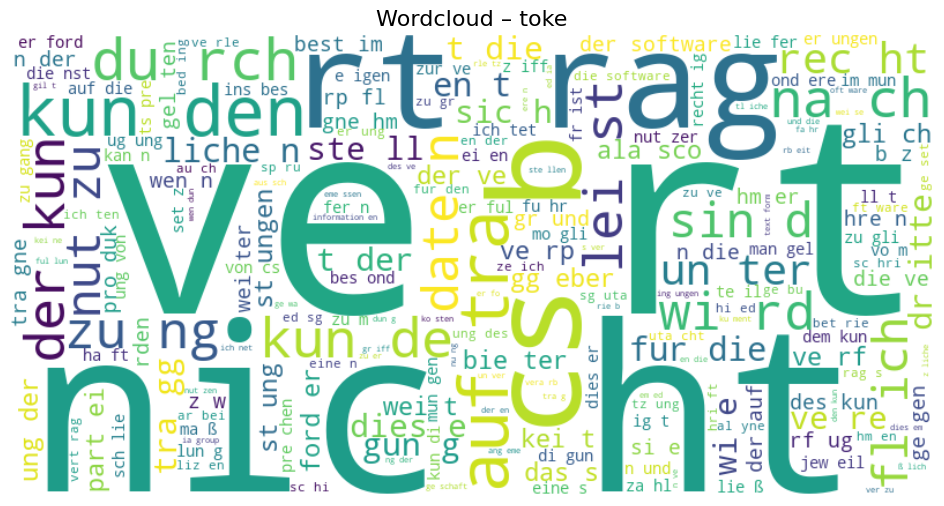

In [18]:
topic_text = " ".join(
    word for tokens in df_structured["paragraph_content_token"].dropna() for word in tokens
)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – toke", fontsize=16)
plt.show()

In [19]:
file_path = '../data/data_clean.xlsx'
df_structured.to_excel(file_path, index=False)

file_path = '../data/data_clean.pkl'  
df_structured.to_pickle(file_path)
